Atividade 07 da disciplina de Visão Robótica

Discente: Henrique Antônio Guanais Corneau

# Estrutura pelo Movimento (SFM)

Dadas várias (n >= 5) imagens, compute a estrutura 3D e movimento
relativo de câmera da cena visualizada utilizando as funções de Structure
from Motion (SFM) da OpenCV. Assumindo uma câmera calibrada
previamente:

1. Extrair pontos e descritores SIFT em duas imagens

Para esse trabalho, está sendo utilizado o dataset kitti_00. Para poder visualizar os gráficos de maneira iterativa, é necessário instalar: `pip install ipympl`.


In [1]:
# $ pip install ipympl
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

[[534.80326845   0.         335.68643204]
 [  0.         534.80326845 240.66183054]
 [  0.           0.           1.        ]]


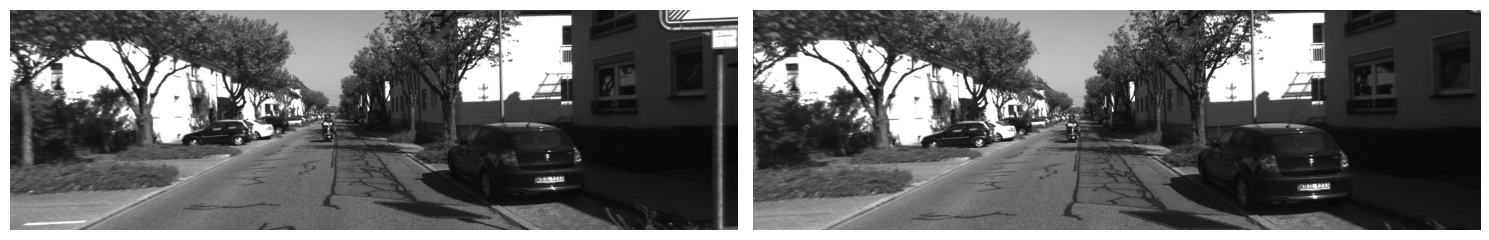

In [2]:
img_dir = '../dataset/kitti_00'
calibration_dir = '../dataset/intrinsics.yml'

img1 = cv2.imread(img_dir + '/000000.png')
img2 = cv2.imread(img_dir + '/000001.png')

def get_camera_intrinsic_matrix(calibration_dir):
    """
    Função que obtém os parâmetros intrínsecos da câmera.

    Parâmetros:
    - calibration_dir: diretório do arquivo de calibração.
    
    Retorna:
    - matrix: matriz de parâmetros intrínsecos da câmera.
    """
    calibration_file = cv2.FileStorage(calibration_dir, cv2.FILE_STORAGE_READ)
    matrix = np.array(calibration_file.getNode('M1').mat())
    calibration_file.release()
    return matrix

K = get_camera_intrinsic_matrix(calibration_dir)
print(K)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()


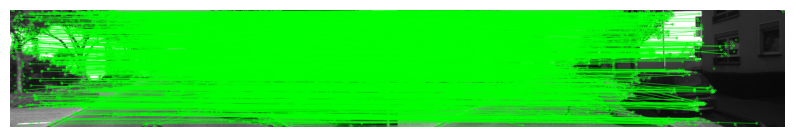

In [3]:
def get_matches_pts(img1, img2):
    """
    Função que retorna os pontos correspondentes entre duas imagens, através do algorithm SIFT e K-D Tree

    Parâmetros:
    - img1: imagem 1
    - img2: imagem 2
    
    Retorna:
    - src_pts: pontos correspondentes da imagem 1
    - dst_pts: pontos correspondentes da imagem 2
    - good_matches: matches válidos
    - kp1: keypoints da imagem 1
    - kp2: keypoints da imagem 2
    """
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # cacula os matches entre os descritores a partir do algoritmo K-D Tree
    index_params = dict(algorithm = 1, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # filtra alguns valores de matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.9 * n.distance:
            good_matches.append(m)

    # pega os pontos correspondentes
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    return src_pts, dst_pts, good_matches, kp1, kp2

src_pts, dst_pts, good_matches, kp1, kp2 = get_matches_pts(img1, img2)

# desenha os matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, matchColor=(0, 255, 0), singlePointColor=(0, 255, 0))
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

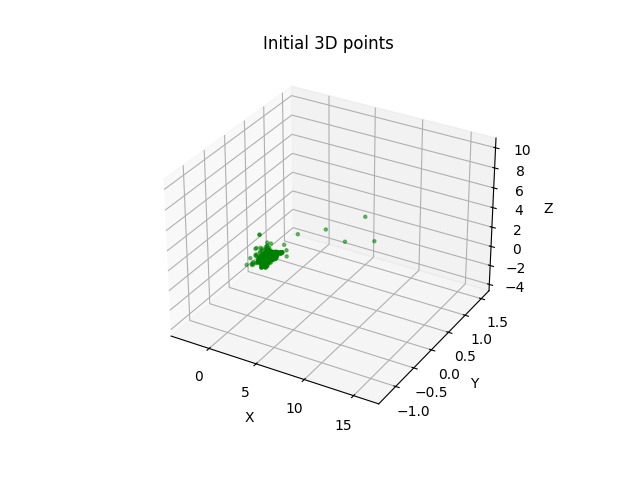

In [17]:
# calcula a matriz essencial
E, _ = cv2.findEssentialMat(src_pts, dst_pts, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# faz a decomposicao da matriz essencial, recuperando a matriz de rotacao e translacao
R, _, t = cv2.decomposeEssentialMat(E)

def triangulate_points(src_pts, dst_pts, K, R, t):
    """
    Função que calcula a triangulação de pontos 3D a partir de pontos correspondentes em duas imagens.

    Parâmetros:
    - src_pts: pontos correspondentes da imagem 1
    - dst_pts: pontos correspondentes da imagem 2
    - K: matriz de parâmetros intrínsecos da câmera
    - R: matriz de rotação
    - t: vetor de translação

    Retorna:
    - points_3D: pontos 3D triangulados
    """
    # matrizes de projecao
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R, t))

    # converte as matrizes de projecao para as coordenadas da camera
    P1 = K @ P1
    P2 = K @ P2

    # triangula os pontos 3D
    points_4D = cv2.triangulatePoints(P1, P2, src_pts, dst_pts)
    
    # converte os pontos de coordenadas homogeneas para cartesianas
    points_3D = points_4D / points_4D[3] 
    points_3D = points_3D[:3, :].T

    return points_3D

points_3D = triangulate_points(src_pts, dst_pts, K, R, t)   

%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plota os pontos 3D
plt.title('Initial 3D points')
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='o', s=5, c='g', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

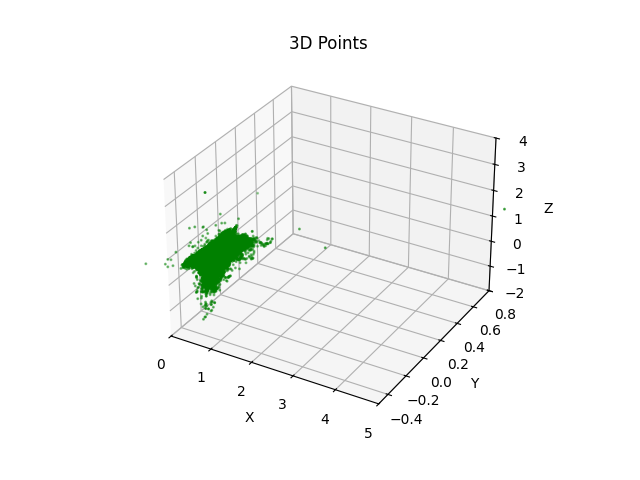

In [15]:

def align_points(points_3D, good_matches, kp2):
    """
    Função que alinha os pontos 3D com os pontos 2D correspondentes.

    Parâmetros:
    - points_3D: pontos 3D
    - good_matches: matches válidos
    - kp2: keypoints da imagem 2

    Retorna:
    - aligned_3D: pontos 3D alinhados
    - aligned_2D: pontos 2D alinhados
    """
    aligned_3D = []
    aligned_2D = []

    for match in good_matches:
        # verifica se o descritor esta dentro do range de pontos
        if match.queryIdx < len(points_3D):
            # ponto 3D correspondente
            point_3d = points_3D[match.queryIdx]
    
            # ponto 2D correspondente
            point_2d = kp2[match.trainIdx].pt

            aligned_3D.append(point_3d)
            aligned_2D.append(point_2d)
    
    aligned_3D = np.array(aligned_3D, dtype=np.float32)
    aligned_2D = np.array(aligned_2D, dtype=np.float32)

    return aligned_3D, aligned_2D


def structure_reconstrution(points_3D, K, img_dir):
    """
    Função que faz a reconstrução da estrutura 3D a partir de uma sequência de imagens.

    Parâmetros:
    - points_3D: pontos 3D iniciais
    - K: matriz de parâmetros intrínsecos da câmera
    - img_dir: diretório das imagens
    """

    # pega todas as imagens .png do diretorio e ordena
    image_files = glob.glob(img_dir + '/*.png')
    image_files = sorted(image_files)

    img_old = cv2.imread(image_files[1])
    poses = []
    for image_path in image_files[2::]:
        new_img = cv2.imread(image_path)
        # faz o match entre a imagem passada e a nova e alinha os pontos 3D
        src_pts, dst_pts, good_matches, _, kp2 = get_matches_pts(img_old, new_img)
        aligned_3D, aligned_2D = align_points(points_3D, good_matches, kp2)

        # realiza o algortimo de PnP
        _, rvec, tvec = cv2.solvePnP(aligned_3D, aligned_2D, K, None)
        # converte a matriz rvec para a matriz de rotacao
        R, _ = cv2.Rodrigues(rvec)
        # triangula os pontos 3D
        new_points_3D = triangulate_points(src_pts, dst_pts, K, R, tvec)

        img_old = new_img
        # adiciona os novos pontos a matriz de pontos 3D
        points_3D = np.vstack([points_3D, new_points_3D])
        # adiciona as posicoes da camera a matriz poses
        poses.append(np.hstack((R, tvec)))

    return points_3D, poses

points_3D, poses = structure_reconstrution(points_3D, K, img_dir)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot dos pontos 3D em verde
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='.', s=5, c='g')

plt.title('3D Points')
ax.set_xlim([0, 5])
ax.set_ylim([-0.5, 0.8])
ax.set_zlim([-2, 4])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()




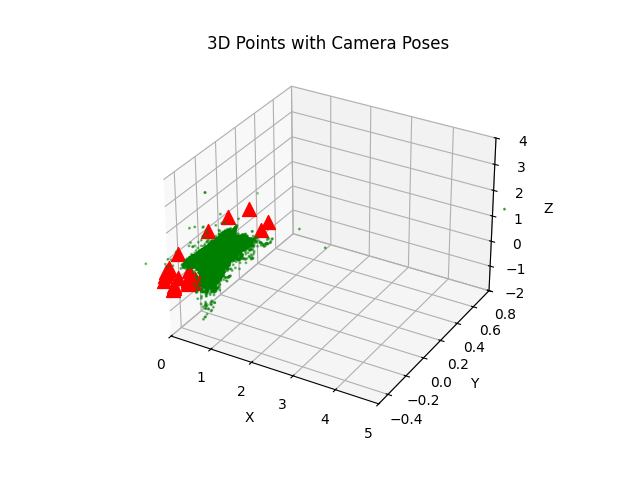

In [16]:
# plot dos pontos 3D com as posicoes da camera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plota os pontos 3D em verde
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='.', s=5, c='g')
ax.set_xlim([0, 5])
ax.set_ylim([-0.5, 0.8])
ax.set_zlim([-2, 4])
plt.title('3D Points with Camera Poses')
for pose in poses:
    # plota a posicao da camera em vermelho
    # pega o vetor de translacao, que representa a posicao da camera
    camera_position = pose[:, 3]  
    ax.scatter(camera_position[0], camera_position[1], camera_position[2], c='r', marker='^', s=100)

# ax.set_axis_off()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()